In [1]:
import numpy as np
np.random.seed(0)

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(100., 50.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

In [3]:
import csv
from tasks.takeoff import Task
from agents.policy_search import PolicySearch_Agent

runtime = 1000.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = PolicySearch_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    state = agent.reset_episode()
    total_reward = 0
    while True:
        rotor_speeds = agent.act(state)
        next_state, reward, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        total_reward += reward
        state = next_state
        if done:
            print("Total episode reward : {}".format(total_reward))
            total_reward = 0
            break

Setting default init pose
Total episode reward : 200.94118321949998


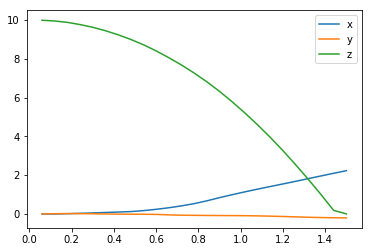

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

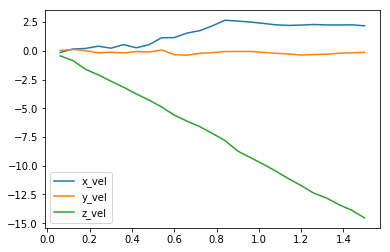

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_vel')
plt.plot(results['time'], results['y_velocity'], label='y_vel')
plt.plot(results['time'], results['z_velocity'], label='z_vel')
plt.legend()
_ = plt.ylim()

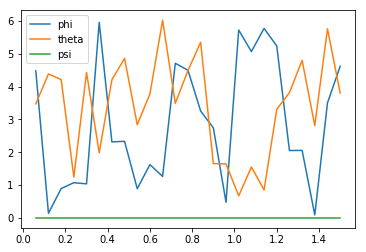

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

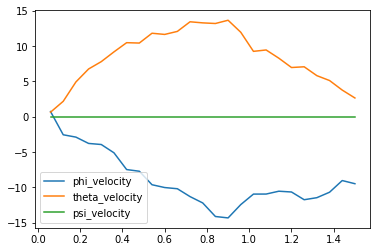

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

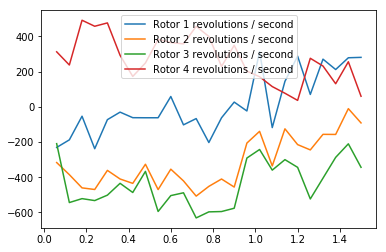

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

In [9]:
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 2.22793002 -0.20786075  0.          4.61875398  3.80842833  0.        ]
[  2.18532764  -0.12253525 -14.53875012]
[-9.4748509  2.652828   0.       ]


In [10]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from tasks.takeoff import Task

num_episodes = 1000
target_pos = np.array([0., 0., 500.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =   4.019 (best =   4.724), noise_scale = 3.25

In [11]:
import sys
import pandas as pd
from agents.agent import DDPG
from tasks.takeoff import Task
import csv

num_episodes = 1000
target_pos = np.array([0., 0., 100.])
task = Task(target_pos=target_pos)
agent = DDPG(task) 
worst_score = 1000000
best_score = -1000000.
reward_log = "reward.txt"

reward_labels = ['episode', 'reward']
reward_results = {x : [] for x in reward_labels}

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [12]:
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    score = 0
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        score += reward
        best_score = max(best_score , score)
        worst_score = min(worst_score , score)
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f} , worst = {:7.3f})".format(
               i_episode, score, best_score, worst_score), end="")
            break
        
    reward_results['episode'].append(i_episode)
    reward_results['reward'].append(score)
    sys.stdout.flush()

Episode = 1000, score = 173.650 (best = 553.282 , worst =   6.439)

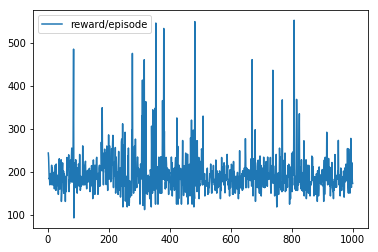

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reward_results['episode'], reward_results['reward'], label='reward/episode')
plt.legend()
_ = plt.ylim()

In [14]:
import csv
from tasks.takeoff import Task

runtime = 5000.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

state = agent.reset_episode()
total_reward = 0
while True:
    rotor_speeds = agent.act(state)
    next_state, reward, done = task.step(rotor_speeds)
    to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
    for ii in range(len(labels)):
        results[labels[ii]].append(to_write[ii])
    total_reward += reward
    state = next_state
    if done:
        print("Total episode reward : {}".format(total_reward))
        total_reward = 0
        break

Setting default init pose
Total episode reward : 256.08236273523113


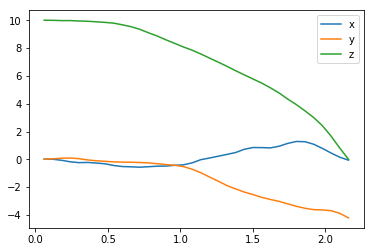

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

In [16]:
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-0.06208294 -4.21957853  0.          2.20250856  4.07640003  0.        ]
[ -2.47506005  -6.40121335 -14.38991791]
[3.92784937 3.32879708 0.        ]


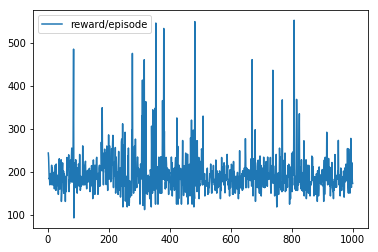

In [17]:
plt.plot(reward_results['episode'], reward_results['reward'], label='reward/episode')
plt.legend()
_ = plt.ylim()

In [18]:
print("Final Performance (Mean Reward over last 10 episodes): {}".format(np.sum(reward_results['reward'][-10:])/10))

Final Performance (Mean Reward over last 10 episodes): 190.78178929888108
